In [56]:
import time

import cv2
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor

from yolort.utils import Visualizer

from PIL import Image
import numpy as np

In [6]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = False if str(device) == "cpu" else True
weights_bcls = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/detection_models/blood/weights/torchscript/traced_bcls-{}.pt".format(device).replace(":0","")
weights_bdet = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/detection_models/blood/weights/torchscript/traced_bdet-{}.pt".format(device).replace(":0","")
weights_fdet = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/detection_models/blood/weights/torchscript/traced_fdet-{}.pt".format(device).replace(":0","")

In [15]:
# load torchscript models 
print("Loading binary model...")
model_bcls = torch.jit.load(weights_bcls)
print("Binary model loaded successfully")

print("Loading detection model...")
model_bdet = torch.jit.load(weights_bdet)
print("Detection model loaded successfully")

print("Loading detection model...")
model_fdet = torch.jit.load(weights_fdet)
print("Detection model loaded successfully")

Loading binary model...
Binary model loaded successfully
Loading detection model...
Detection model loaded successfully
Loading detection model...
Detection model loaded successfully


In [105]:
# input data and transform (using opencv)
#filename = "/home/ajvalenc/Datasets/spectronix/thermal/reference/T_IM_45.png"
filename = "/home/ajvalenc/Datasets/spectronix/thermal/blood/16bit/s01_thermal_cloth_01_MicroCalibir_M0000334/0001.png"
img = cv2.imread(filename,cv2.IMREAD_ANYDEPTH) #input

In [109]:
def sixteen_bits2eight_bits(pixel):
    # Pseudo colouring the 16 bit images
    pixel = (pixel - np.min(pixel)) / (30100-np.min(pixel))
    pixel = np.rint(pixel * 255)
    return pixel.astype("uint8")

In [111]:
# conversion
img = sixteen_bits2eight_bits(img)

# channels
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

img = torch.as_tensor(img.astype("float32").transpose(2,0,1)).to(device)
img /= 255.
img = img.unsqueeze(0)

In [112]:
# dry run
for i in range(5):
    model_bcls(img)
    model_bdet(img)
    model_fdet(img)

In [113]:
with torch.no_grad(): #ensures autograd is off
    start = time.time()
    out_bcls = model_bcls(img)
    end = time.time()
    print("Blood classification runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_bdet = model_bdet(img)
    end = time.time()
    print("Blood detection runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_fdet = model_fdet(img)
    end = time.time()
    print("Face detection runtime [ms]: ", 1000*(end-start))

Blood classification runtime [ms]:  1496.6378211975098
Blood detection runtime [ms]:  244.30060386657715
Face detection runtime [ms]:  211.52639389038086


In [115]:
print("Output bdet:", out_bdet[1][0])
print("Output fdet:", out_fdet[1][0])

Output bdet: {'scores': tensor([0.85037, 0.68136]), 'labels': tensor([0, 1]), 'boxes': tensor([[446.11957, 334.78891, 492.61072, 443.46506],
        [187.64490, 286.04041, 246.92917, 357.55988]])}
Output fdet: {'scores': tensor([0.83816]), 'labels': tensor([0]), 'boxes': tensor([[189.75500,  83.40294, 223.09647, 123.40352]])}


In [116]:
def visualize(image, normalize=False):

    if normalize:
        image = cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 

    # rescale (16-bit image only) see method 2 https://answers.opencv.org/question/207313/conversion-16bit-image-to-8-bit-image/
    if (image.dtype) == np.uint16:
        image = image / 257
        image = image.astype(np.uint8)

    #cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

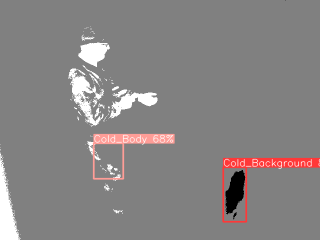

In [117]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(visualize(img_raw, True), ["Cold_Background", "Cold_Body", "Warm_Background", "Warm_Body", "Warm_Dripping"])
v.draw_instance_predictions(out_bdet[1][0])
v.imshow(scale=0.5)

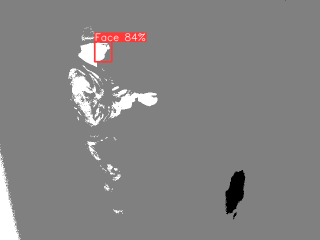

In [118]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(visualize(img_raw,True), ["Face", "ForeHead"])
v.draw_instance_predictions(out_fdet[1][0])
v.imshow(scale=0.5)